# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
trainTransform = transforms.Compose([transforms.RandomRotation(45),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomVerticalFlip(),
                                     transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

testTransform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

# Create training set and define training dataloader
data_folder=os.path.join(os.getcwd(), '/data')
batch=64

cifar10_train=torchvision.datasets.CIFAR10(root=data_folder,download=True, train=True,
                                          transform=trainTransform)
trainloader = torch.utils.data.DataLoader(cifar10_train,
                                          batch_size=batch,
                                          shuffle=True)

# Create test set and define test dataloader
cifar10_test=torchvision.datasets.CIFAR10(root=data_folder,download=True,
                                          transform=testTransform)
testloader = torch.utils.data.DataLoader(cifar10_test,
                                          batch_size=batch*2)
# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    print(images.shape)
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()


torch.Size([5, 3, 32, 32])
car


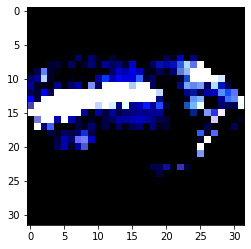

car


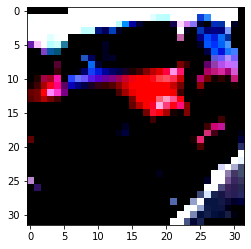

horse


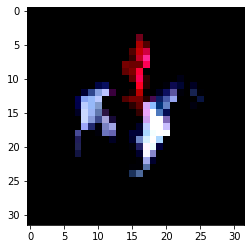

cat


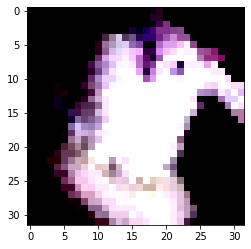

frog


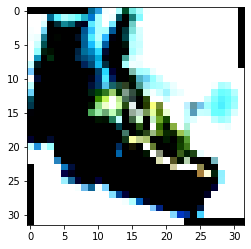

In [4]:
# Explore data
show5(trainloader)

torch.Size([5, 3, 32, 32])
frog


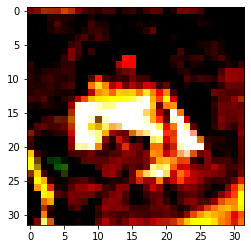

truck


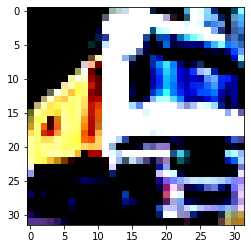

truck


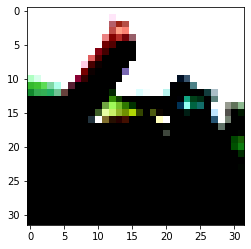

deer


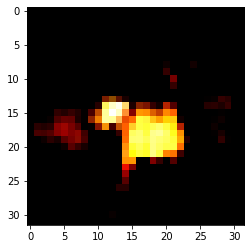

car


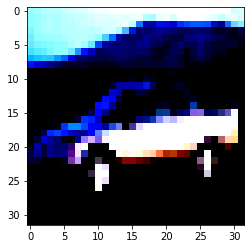

In [5]:
show5(testloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [6]:
# define a feedforward neural network
class Classifier(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # fully connected layers
        self.conv1 = nn.Conv2d(3, 64, 2, stride=1, padding=1, dilation=2)
        self.conv2 = nn.Conv2d(64, 128, 2, stride =1, padding=1, dilation=2)
        self.conv3 = nn.Conv2d(128, 256, 2, stride=1, padding=1, dilation=2) 
        self.conv4 = nn.Conv2d(256, 512, 2, stride=1, padding=1, dilation=2) 
        self.conv5 = nn.Conv2d(512, 1024, 2, stride=1, padding=1, dilation=2)
        
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # dropout layer
        self.dropout = nn.Dropout(p=0.1)
        
    def forward(self, x):
#         print(x.shape)
        
        x = self.dropout(F.relu(F.max_pool2d(self.conv1(x), stride=2, kernel_size=2, ceil_mode=True)))
        x = self.dropout(F.relu(F.max_pool2d(self.conv2(x), stride=2, kernel_size=2, ceil_mode=True)))
        x = self.dropout(F.relu(F.max_pool2d(self.conv3(x), stride=2, kernel_size=2, ceil_mode=True)))
        x = self.dropout(F.relu(F.max_pool2d(self.conv4(x), stride=2, kernel_size=2, ceil_mode=True)))
        x = self.dropout(F.relu(F.max_pool2d(self.conv5(x), stride=2, kernel_size=2, ceil_mode=True)))
        
        
        # flatten the input image
        x = x.view(x.shape[0], -1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # output layer no dropout required
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [7]:
# instantiate model
model = Classifier()

# define the loss
criterion = nn.NLLLoss()

# define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.002)


## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [8]:
if torch.cuda.is_available():
    model.cuda()
    
def setCuda(images, labels):
    images = images.cuda()
    labels = labels.cuda() 
    
    return images, labels
    
train_losses, test_losses = [], []

epoch = 25

for i in range(epoch):
    train_loss=0
    for images, labels in trainloader:

        # train with gpu if available
        if torch.cuda.is_available():
            images, labels = setCuda(images, labels)
        
        # zero the gradients
        optimizer.zero_grad()
        
        # train the model and calculate losses
        logps= model(images)
        loss = criterion(logps, labels)
        train_loss += loss
        
        
        # back propagate
        loss.backward()
        # take an optimization step
        optimizer.step()
            
    else:
        with torch.no_grad():
            test_loss = 0
            accuracy=0
            model.eval()
            for images, labels in testloader:
                if torch.cuda.is_available():
                    images, labels = setCuda(images, labels)
                    
                # get predictions
                logps = model(images)
                test_loss += criterion(logps, labels)
                
                # compute the accuracy
                ps=torch.exp(logps)
                top_ps, top_labels = ps.topk(1, dim=1)
                equals = top_labels == labels.view(*top_labels.shape)
                accuracy += equals.float().mean()
        model.train()
        train_losses.append(train_loss.cpu()/len(trainloader))
        test_losses.append(test_loss.cpu()/len(testloader))
        print(f"Epoch: {i+1}/{epoch}... Training Loss: {train_loss/len(trainloader):.3f}... Validation Loss: {test_loss/len(testloader):.3f}... Accuracy: {accuracy/len(testloader):.3f}")

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch: 1/25... Training Loss: 1.984... Validation Loss: 1.737... Accuracy: 0.306
Epoch: 2/25... Training Loss: 1.738... Validation Loss: 1.565... Accuracy: 0.408
Epoch: 3/25... Training Loss: 1.630... Validation Loss: 1.494... Accuracy: 0.449
Epoch: 4/25... Training Loss: 1.566... Validation Loss: 1.419... Accuracy: 0.485
Epoch: 5/25... Training Loss: 1.522... Validation Loss: 1.365... Accuracy: 0.491
Epoch: 6/25... Training Loss: 1.486... Validation Loss: 1.343... Accuracy: 0.520
Epoch: 7/25... Training Loss: 1.459... Validation Loss: 1.289... Accuracy: 0.534
Epoch: 8/25... Training Loss: 1.435... Validation Loss: 1.315... Accuracy: 0.531
Epoch: 9/25... Training Loss: 1.422... Validation Loss: 1.260... Accuracy: 0.551
Epoch: 10/25... Training Loss: 1.406... Validation Loss: 1.250... Accuracy: 0.561
Epoch: 11/25... Training Loss: 1.400... Validation Loss: 1.307... Accuracy: 0.529
Epoch: 12/25... Training Loss: 1.382... Validation Loss: 1.217... Accuracy: 0.568
Epoch: 13/25... Training 

Plot the training loss (and validation loss/accuracy, if recorded).

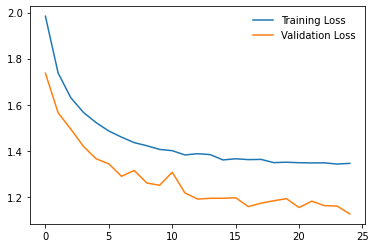

In [9]:
plt.plot([loss.detach().numpy() for loss in train_losses], label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.legend(frameon=False);

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [13]:
accuracy = 0
for images, labels in testloader:
    model.eval()
    images = images.cuda()
    labels = labels.cuda()
    
    logps = model(images)
    ps = torch.exp(logps)

    top_ps, top_labels = ps.topk(1, dim=1)

    equals = top_labels == labels.view(*top_labels.shape)

    accuracy += equals.float().mean()

print(f"Acuuracy: {(accuracy/len(testloader))*100:.1f}%")

Acuuracy: 60.0%


## Saving your model
Using `torch.save`, save your model for future loading.

In [11]:
torch.save(model.state_dict(), 'classifier.pth')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?

**Recommendation is to `"build"`** for the following reasons.


Though this model does not perform as well as the Detectocorp's model (60% against 70%) but with a little more work and fine tuning, a higher accuracy than that of the Detectocorp can be achieved. Also, compared to the more advanced solutions provided, this model can be said to have performed well on average.

To obtain the current accuracy, the following steps were taken:
- Data Augmentation transforms which includes rotation, horizontal and vertical flipping of the training images.
- Implementation of the convolution layer as the linear layers were not sufficient for the data.

In conclusion, before this model can be used in production this need for more work to improve the accuracy. Some of the additional work include but not limited to.
- Model regularization such as learning rate optimization using the optim learning rate scheduler
- Implementation of a residual neural network (RESNET) as described [here](https://en.wikipedia.org/wiki/Residual_neural_network) and implemented [here](https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans/lesson/lesson-5-data-augmentation-regularization-and-resnets) to achieve a 90% accuracy.

## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).